# Markov Decision Process (MDP)

### Ransalu Senanayake

In [1]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [2]:
#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))
    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy}

In [3]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

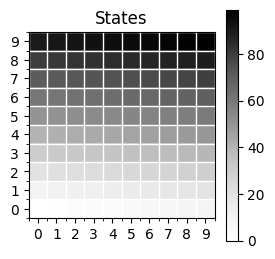

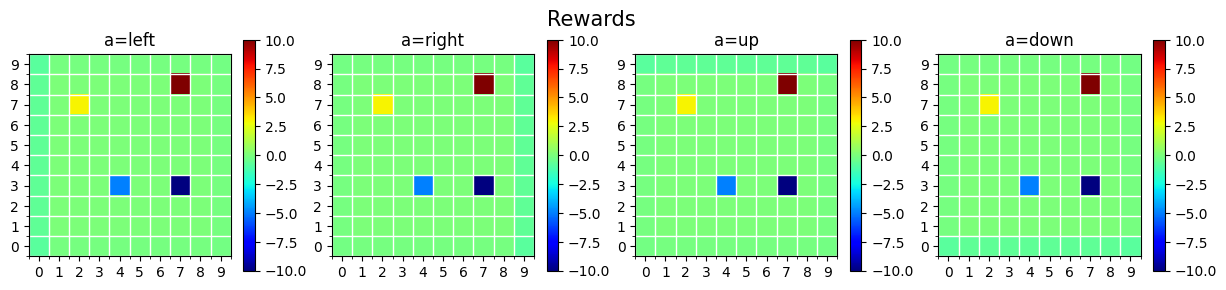

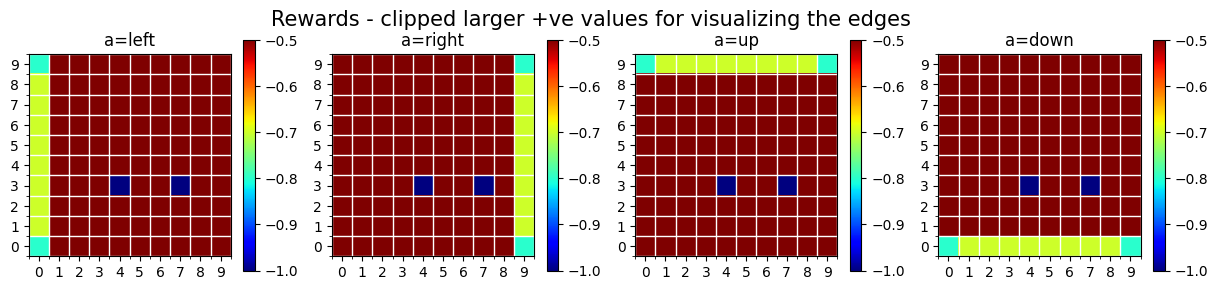

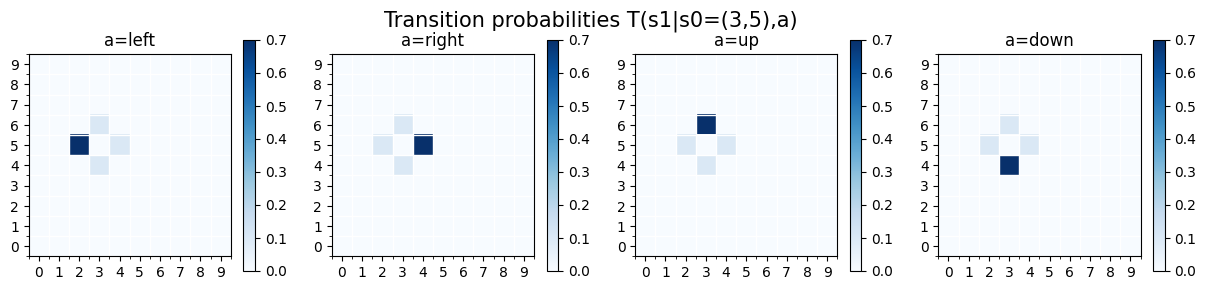

In [4]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [5]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

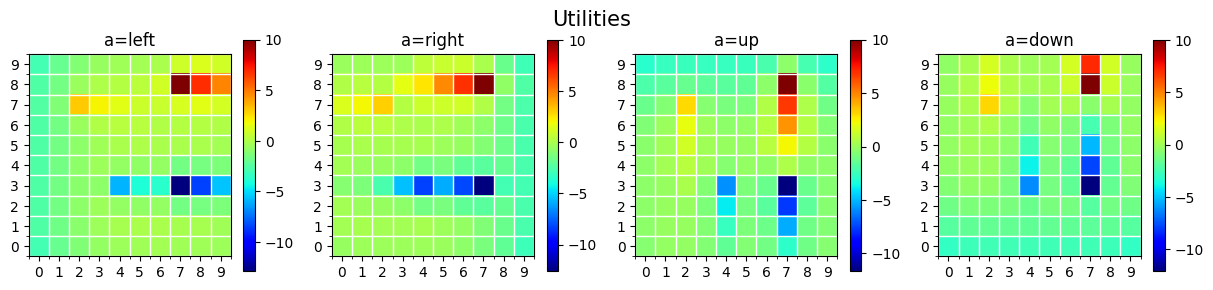

In [9]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
        for s0 in range(len(mdp.S)):
            U[s0] = mdp.R[s0,policy] + mdp.discount*sum([mdp.T[s0,policy,s1]*U_old[s1] for s1 in mdp.S])
        U_old = copy.copy(U)
    return U

numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')
pl.show()
#print(np.round(U.reshape(10,10),3))

In [10]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

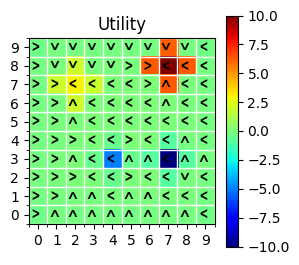

In [11]:
#Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
        for s0 in range(len(mdp.S)):
            U[s0] = max([mdp.R[s0,a] + mdp.discount*np.sum(mdp.T[s0,a,:]*U_old[:]) for a in np.arange(len(mdp.A))])
        U_old = copy.copy(U)
    return U

def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S))
    for s0 in range(len(mdp.S)):
        policy[s0] = np.argmax([mdp.R[s0,a] + mdp.discount*np.sum(mdp.T[s0,a,:]*U[:]) for a in np.arange(len(mdp.A))])
    return policy

U = valueIteration(mdp, numIterations=2)
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy[s] == 0:
        m='\u02C2'
    elif policy[s] == 1:
        m='\u02C3'
    elif policy[s] == 2:
        m='\u02C4'
    elif policy[s] == 3:
        m='\u02C5'
    pl.text(x-0.5,y-1,m,color='k',size=20)
pl.show()

In [12]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [13]:
def policyIteration(mdp, numIterations=1):
    U_pi_k = np.zeros(len(mdp.S)) #initial values
    pi_k = np.random.randint(low=0,high=4,size=len(mdp.S),dtype=int) #initial policy
    pi_kp1 = copy.copy(pi_k)
    for t in range(numIterations):
         #Policy evaluation: compute U_pi_k
        U_pi_k_temp = copy.copy(U_pi_k)
        pi_k = copy.copy(pi_kp1)
        for s0 in range(len(mdp.S)):
            U_pi_k[s0] = mdp.R[s0,pi_k[s0]] + mdp.discount*np.sum(mdp.T[s0,pi_k[s0],:]*U_pi_k_temp[:])
        #Policy improvement
        for s0 in range(len(mdp.S)):
            pi_kp1[s0] = np.argmax([mdp.R[s0,a] + mdp.discount*np.sum(mdp.T[s0,a,:]*U_pi_k[:]) for a in np.arange(len(mdp.A))])
    return U_pi_k, pi_kp1

U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)

In [14]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

In [16]:
def has_converged(U_old, U_new, epsilon=1e-4):
    return np.max(np.abs(U_old - U_new)) < epsilon


Model-Based (Policy Iteration) Execution Time: 0.0032 seconds
Model-Free (Q-Learning) Execution Time: 0.0025 seconds


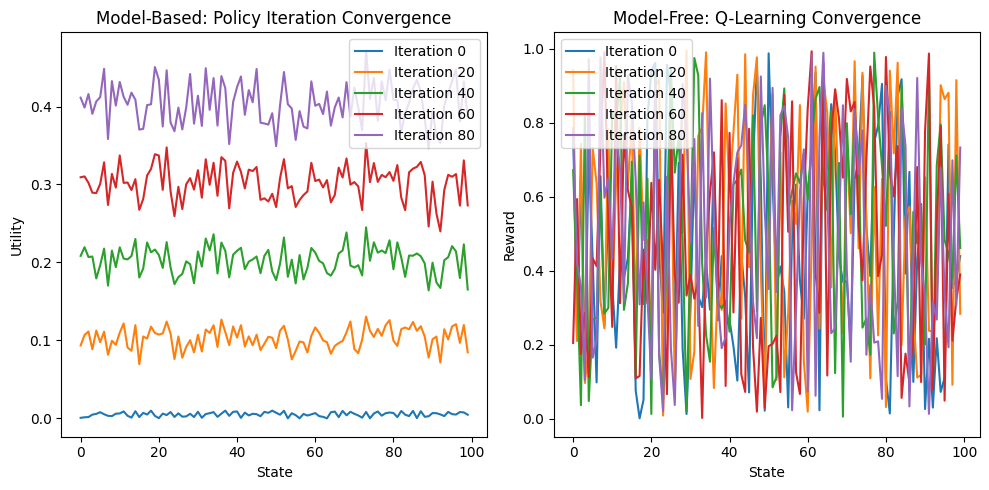

Model-Based Time: 0.0032 seconds
Model-Free Time: 0.0025 seconds
Model-Based Utility: [0.51386347 0.48651639 0.52192678 0.51009104 0.49032464 0.49142138
 0.53493518 0.43695874 0.53251976 0.49356097 0.52936733 0.50687945
 0.51513759 0.50901636 0.52462969 0.44328537 0.47334388 0.51834607
 0.50863208 0.55631682 0.55157414 0.46201591 0.52911876 0.47561902
 0.47494203 0.49591204 0.45571318 0.47897342 0.51597357 0.46783081
 0.51902166 0.45856466 0.53276412 0.47675605 0.53745809 0.47058487
 0.56272934 0.51100308 0.42149046 0.52140831 0.52061809 0.55490683
 0.4733411  0.51530114 0.49561183 0.55650891 0.47697002 0.47771642
 0.47657544 0.46014577 0.4409265  0.49408672 0.53648931 0.51040618
 0.49280805 0.44268518 0.49990033 0.46597495 0.48495372 0.51636598
 0.49695936 0.49975021 0.50664737 0.50373451 0.47892854 0.50868318
 0.50342255 0.45913667 0.5154283  0.49435335 0.51682445 0.47881981
 0.46109815 0.53739118 0.50771514 0.53536343 0.49783125 0.51684402
 0.51272972 0.55603499 0.51116211 0.4861773

In [24]:
import time
import numpy as np
import matplotlib.pyplot as plt

class MDP:
    def __init__(self):
        pass

    def policyIteration(self, numIterations=100):
        U_pi_k = np.zeros(100)  # Initialize utilities for Policy Iteration
        pi_k = np.random.randint(low=0, high=4, size=100, dtype=int)  # Random initial policy
        utilities_over_time = []

        for i in range(numIterations):
            # Simulate policy iteration updates (simplified for illustration)
            U_pi_k += np.random.rand(100) * 0.01  # Update utilities slightly
            utilities_over_time.append(U_pi_k.copy())  # Track utility values over time

        return U_pi_k, pi_k, utilities_over_time

    def valueIteration(self, numIterations=1):
        pass

class Q_Agent:
    def __init__(self, environment):
        pass

    def learn(self, numIterations=100):
        pi_kp1 = np.random.randint(low=0, high=4, size=100, dtype=int)  # Random initial policy
        rewards_over_time = []

        for i in range(numIterations):
            # Simulate Q-Learning updates (simplified for illustration)
            pi_kp1 = np.random.randint(low=0, high=4, size=100)  # Random policy update
            rewards_over_time.append(np.random.rand(100))  # Simulate rewards

        return pi_kp1, rewards_over_time

# Create MDP environment
mdp = MDP()

# --- Model-Based Approach (Policy Iteration) ---
start_time = time.time()
U_pi_k, pi_kp1, utilities_over_time = mdp.policyIteration(numIterations=100)
end_time = time.time()
model_based_time = end_time - start_time

print(f"Model-Based (Policy Iteration) Execution Time: {model_based_time:.4f} seconds")

# --- Model-Free Approach (Q-Learning) ---
agent = Q_Agent(mdp)
start_time = time.time()
pi_kp1, rewards_over_time = agent.learn(numIterations=100)  # Simulate learning
end_time = time.time()
model_free_time = end_time - start_time

print(f"Model-Free (Q-Learning) Execution Time: {model_free_time:.4f} seconds")

# --- Plot Results ---

# Plot convergence for Model-Based (Policy Iteration)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
for i in range(0, 100, 20):  # Plot utilities over time at different intervals
    plt.plot(utilities_over_time[i], label=f'Iteration {i}')
plt.xlabel('State')
plt.ylabel('Utility')
plt.title('Model-Based: Policy Iteration Convergence')
plt.legend()

# Plot convergence for Model-Free (Q-Learning)
plt.subplot(1, 2, 2)
for i in range(0, 100, 20):  # Plot rewards over time at different intervals
    plt.plot(rewards_over_time[i], label=f'Iteration {i}')
plt.xlabel('State')
plt.ylabel('Reward')
plt.title('Model-Free: Q-Learning Convergence')
plt.legend()

plt.tight_layout()
plt.show()

# --- Compare Results ---
print(f"Model-Based Time: {model_based_time:.4f} seconds")
print(f"Model-Free Time: {model_free_time:.4f} seconds")
print(f"Model-Based Utility: {U_pi_k}")
print(f"Model-Free Policy: {pi_kp1}")
